In [35]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy.stats import shapiro

# Statistical Modeling and Machine Learning
from sklearn import model_selection, metrics, linear_model, ensemble
import statsmodels.api as sm
from scipy import stats
from scipy.stats import ttest_ind


In [2]:
fangraphs_data = pd.read_csv("fangraphs_season_level.csv")
savant_data = pd.read_csv("savant_pitch_level.csv")

In [16]:
# Define your thresholds
threshold_g_MR = 21  # 50th percentile
threshold_gs_MR = 1  # Slightly above minimum
min_ip_MR = 16.1     # 25th percentile
max_ip_MR = 112.1    # 75th percentile
threshold_percentage_LS = 0.75  # Hypothetical value, adjust based on your analysis
threshold_gmli_SU = 0.955314  # 75th percentile
threshold_hld_SU = 1          # 75th percentile

threshold_sv_CL = 20  # High number of saves for Closers
min_ip_LR = 40        # Minimum innings pitched for Long Relievers
balance_threshold_SW = 0.3  # Minimum balance ratio of GS to (G-GS) for Swingmen



# Closer
def is_closer(row):
    return row['SV'] > threshold_sv_CL

# Long Reliever
def is_long_reliever(row):
    return (row['IP'] > min_ip_LR) and not is_middle_reliever(row)

# Swingman
def is_swingman(row):
    return row['GS'] / max(row['G'] - row['GS'], 1) > balance_threshold_SW

# Middle Reliever
def is_middle_reliever(row):
    return row['G'] > threshold_g_MR and row['GS'] < threshold_gs_MR and min_ip_MR <= row['IP'] <= max_ip_MR

# Lefty Specialist
def is_lefty_specialist(player_id):
    left_handed_batters_faced = savant_data[savant_data['stand'] == 'L'].groupby('pitcher').size().get(player_id, 0)
    total_batters_faced = savant_data.groupby('pitcher').size().get(player_id, 1)  # avoid division by zero
    percentage_left_handed_batters_faced = left_handed_batters_faced / total_batters_faced
    return percentage_left_handed_batters_faced > threshold_percentage_LS

# Setup Man
def is_setup_man(row):
    return row['gmLI'] > threshold_gmli_SU and row['HLD'] > threshold_hld_SU

fangraphs_data['additional_role'] = fangraphs_data.apply(
    lambda row: 'Middle Reliever' if is_middle_reliever(row) else
                'Lefty Specialist' if is_lefty_specialist(row['MLBAMID']) else
                'Setup Man' if is_setup_man(row) else
                'Closer' if is_closer(row) else
                'Long Reliever' if is_long_reliever(row) else
                'Swingman' if is_swingman(row) else
                'Other', axis=1)

# Review the categorization
print(fangraphs_data['additional_role'].value_counts())


Other               1249
Middle Reliever      845
Long Reliever        585
Swingman             556
Setup Man             68
Lefty Specialist      22
Name: additional_role, dtype: int64


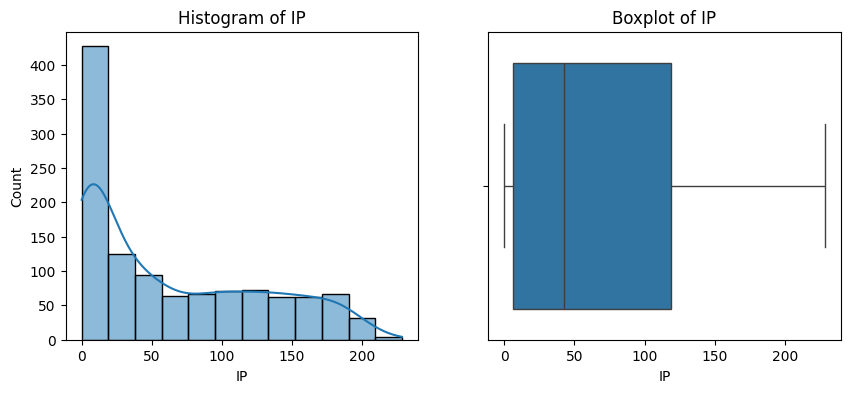

Shapiro-Wilk Test for IP - Statistics=0.867050290107727, p=4.259238082520867e-30
Sample does not look Gaussian (not normally distributed).
Mean for IP: 64.96204188481676
Median for IP: 42.2

---



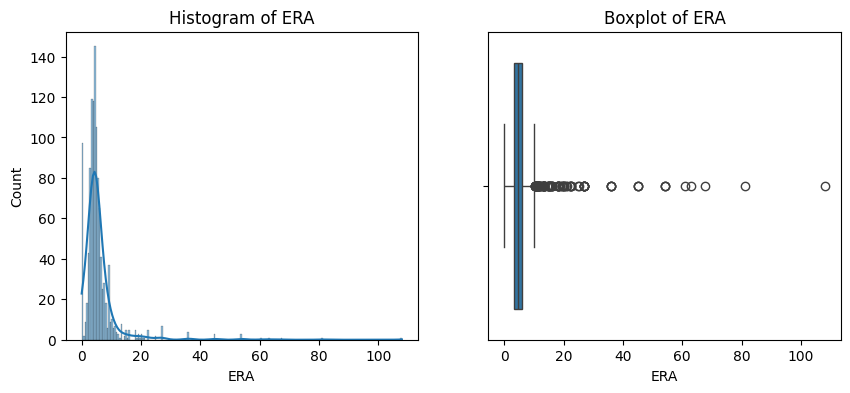

Shapiro-Wilk Test for ERA - Statistics=0.46953070163726807, p=0.0
Sample does not look Gaussian (not normally distributed).
Mean for ERA: 5.803644106579407
Median for ERA: 4.5

---



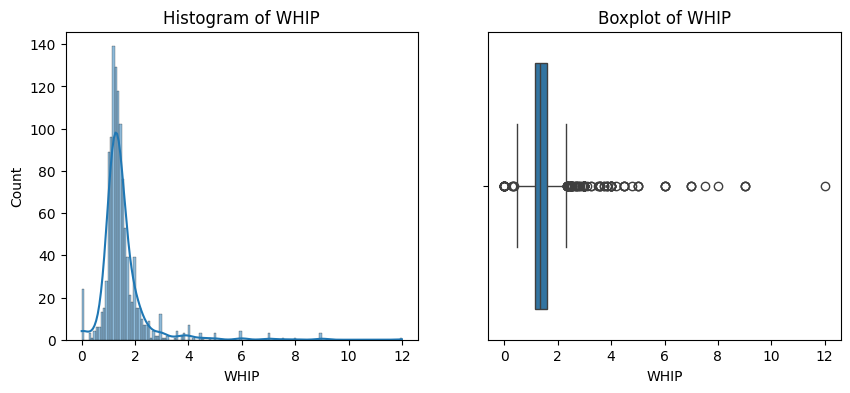

Shapiro-Wilk Test for WHIP - Statistics=0.6004042029380798, p=2.802596928649634e-45
Sample does not look Gaussian (not normally distributed).
Mean for WHIP: 1.5173324076727748
Median for WHIP: 1.333333333

---



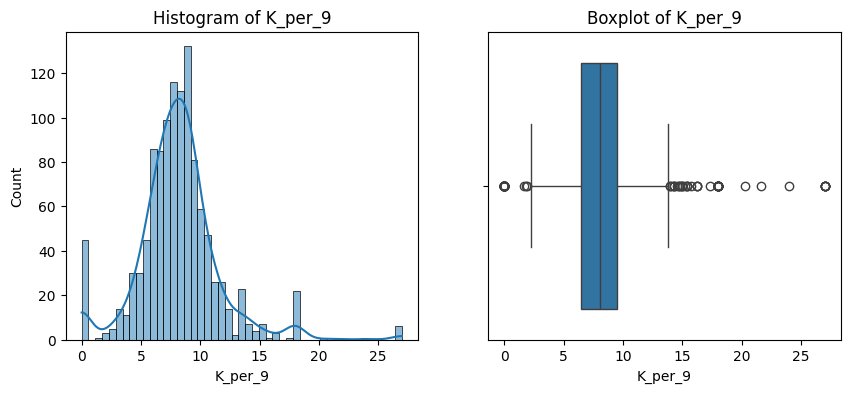

Shapiro-Wilk Test for K_per_9 - Statistics=0.9019232988357544, p=1.8381012218729603e-26
Sample does not look Gaussian (not normally distributed).
Mean for K_per_9: 8.182956809201572
Median for K_per_9: 8.059713653

---



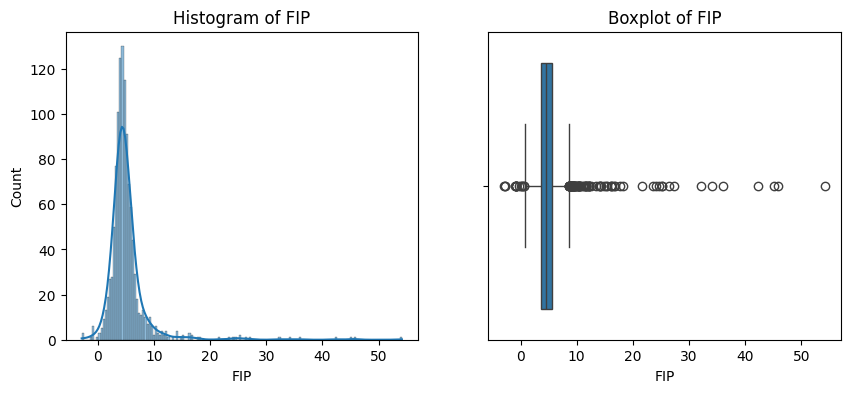

Shapiro-Wilk Test for FIP - Statistics=0.5337246656417847, p=0.0
Sample does not look Gaussian (not normally distributed).
Mean for FIP: 5.155993918172775
Median for FIP: 4.4806284055

---



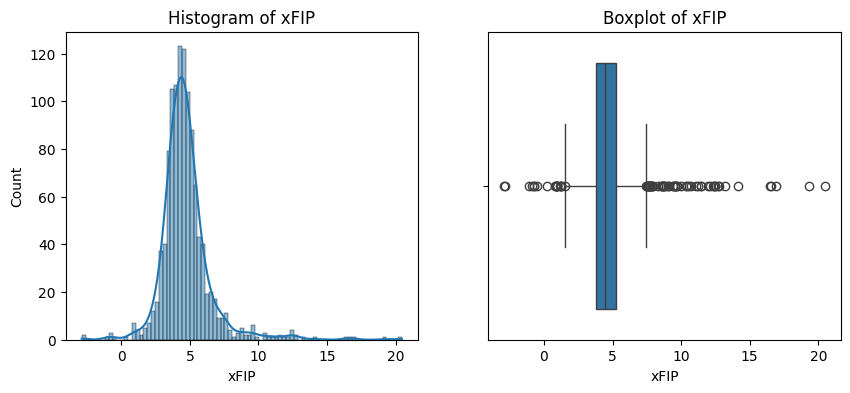

Shapiro-Wilk Test for xFIP - Statistics=0.7997956871986389, p=2.225910477792944e-35
Sample does not look Gaussian (not normally distributed).
Mean for xFIP: 4.707606318438918
Median for xFIP: 4.482097994

---



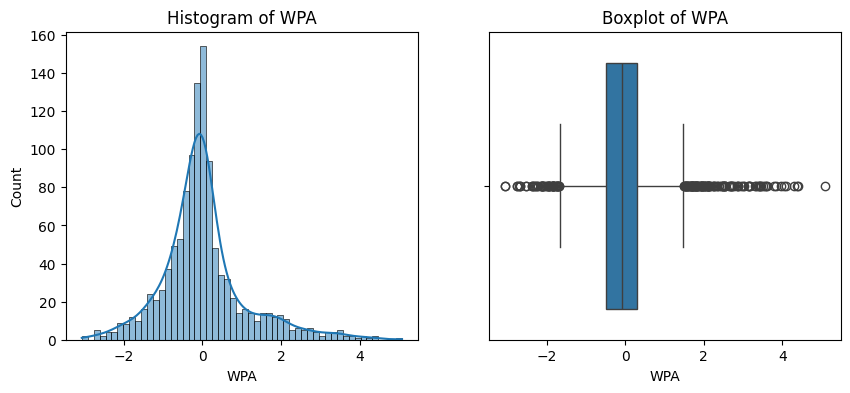

Shapiro-Wilk Test for WPA - Statistics=0.9209495782852173, p=4.915487358171204e-24
Sample does not look Gaussian (not normally distributed).
Mean for WPA: 0.023287459227748688
Median for WPA: -0.0752770005

---



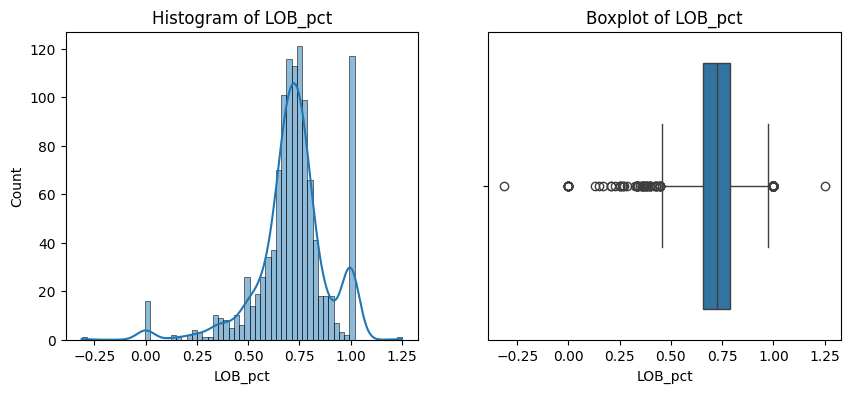

Shapiro-Wilk Test for LOB_pct - Statistics=0.8952250480651855, p=3.1332441967870733e-27
Sample does not look Gaussian (not normally distributed).
Mean for LOB_pct: 0.7142422338568936
Median for LOB_pct: 0.72245

---



In [21]:
#Starting pitcher success analysis
starting_pitchers = fangraphs_data[fangraphs_data['Role'] == 'SP']
metrics_sp = ['IP', 'ERA', 'WHIP', 'K_per_9', 'FIP', 'xFIP', 'WPA', 'LOB_pct']

# Visualizing the distribution of each metric
for metric in metrics_sp:
    plt.figure(figsize=(10, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(starting_pitchers[metric], kde=True)
    plt.title(f'Histogram of {metric}')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=starting_pitchers[metric])
    plt.title(f'Boxplot of {metric}')

    plt.show()

    # Shapiro-Wilk Test
    stat, p = shapiro(starting_pitchers[metric].dropna())
    print(f'Shapiro-Wilk Test for {metric} - Statistics={stat}, p={p}')
    if p > 0.05:
        print('Sample looks Gaussian (normal distribution).')
    else:
        print('Sample does not look Gaussian (not normally distributed).')

    # Compare Mean and Median
    mean_value = starting_pitchers[metric].mean()
    median_value = starting_pitchers[metric].median()
    print(f'Mean for {metric}: {mean_value}')
    print(f'Median for {metric}: {median_value}')
    print('\n---\n')



In [22]:
sp_metrics_summary = starting_pitchers[metrics_sp].median()

In [29]:
sp_ids = starting_pitchers['MLBAMID'].unique()
sp_pitches = savant_data[savant_data['pitcher'].isin(sp_ids)]
sp_pitch_types = sp_pitches.groupby(['pitcher', 'pitch_type']).size().unstack().fillna(0)
sp_velocity = sp_pitches.groupby('pitcher')['release_speed'].mean()
sp_spin_rate = sp_pitches.groupby('pitcher')['release_spin_rate'].mean()


sp_velocity = sp_velocity.reset_index()
sp_spin_rate = sp_spin_rate.reset_index()

sp_velocity = sp_velocity.rename(columns={'pitcher': 'MLBAMID'})
sp_spin_rate = sp_spin_rate.rename(columns={'pitcher': 'MLBAMID'})


starting_pitchers = starting_pitchers.merge(sp_pitch_types, left_on='MLBAMID', right_index=True, how='left')
starting_pitchers = starting_pitchers.merge(sp_velocity, on='MLBAMID', how='left')
starting_pitchers = starting_pitchers.merge(sp_spin_rate, on='MLBAMID', how='left')


In [33]:
# Define successful starting pitchers
success_criteria = (starting_pitchers['ERA'] <= sp_metrics_summary['ERA']) & (starting_pitchers['WHIP'] <= sp_metrics_summary['WHIP'])
successful_sp = starting_pitchers[success_criteria]
# Compare metrics of successful and less successful starting pitchers
less_successful_sp = starting_pitchers[~success_criteria]

# For each metric, you can compare the distributions, means, or medians
for metric in metrics_sp:
    median_successful = successful_sp[metric].median()
    median_less_successful = less_successful_sp[metric].median()
    print(f"Median {metric} for successful SP: {median_successful}")
    print(f"Median {metric} for less successful SP: {median_less_successful}")
    print('\n---\n')


Median IP for successful SP: 91.0
Median IP for less successful SP: 28.2

---

Median ERA for successful SP: 3.25
Median ERA for less successful SP: 5.661294677

---

Median WHIP for successful SP: 1.120084892
Median WHIP for less successful SP: 1.535998828

---

Median K_per_9 for successful SP: 8.776503448
Median K_per_9 for less successful SP: 7.641494859

---

Median FIP for successful SP: 3.691217877
Median FIP for less successful SP: 5.222020024

---

Median xFIP for successful SP: 3.855390331
Median xFIP for less successful SP: 4.920471963

---

Median WPA for successful SP: 0.454019994
Median WPA for less successful SP: -0.351980001

---

Median LOB_pct for successful SP: 0.7759
Median LOB_pct for less successful SP: 0.6782

---



In [36]:
for metric in metrics_sp:
    stat, p = ttest_ind(successful_sp[metric].dropna(), less_successful_sp[metric].dropna())
    print(f"{metric}: Statistics={stat}, p-value={p}")

IP: Statistics=11.045296559364392, p-value=5.070762569743373e-27
ERA: Statistics=-12.339163373771338, p-value=6.246691828908943e-33
WHIP: Statistics=-16.277220301573436, p-value=9.675239450717705e-54
K_per_9: Statistics=5.097893317148343, p-value=4.01624611892655e-07
FIP: Statistics=-11.895431093249215, p-value=7.568061699405306e-31
xFIP: Statistics=-13.880541485478991, p-value=1.3334127031939873e-40
WPA: Statistics=26.259330345941986, p-value=2.5134379386605076e-119
LOB_pct: Statistics=14.701835416845652, p-value=6.01457837389032e-45
